<a href="https://colab.research.google.com/github/drscicomm/food-security/blob/main/Tigray_BERTopic_Stage_1_PreConflict_20241015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERTopic FAQ: https://maartengr.github.io/BERTopic/faq.html#i-have-only-a-few-topics-how-do-i-increase-them

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
output_path = '/content/gdrive/MyDrive/Tigray 20241009'

In [ ]:
# Step 1: Install Dependencies
!pip install bertopic
!pip install umap-learn
!pip install calplot


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8117 sha256=6015deedb7084a06b92732e05fe183c90aac7a1925cdabe7f1170182becc9a0f
  Stored in directory: /root/.cache/pip/wheels/77/75/32/a518a4a1421776a93e1ede33cb8dac474095bf31fed7e4e22c
Successfully built calplot


In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
# Step 2: Import Libraries
import pandas as pd
import re
from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer
from umap import UMAP
import calplot
import matplotlib.pyplot as plt
from hdbscan import HDBSCAN  # Make sure you have the library installed
from umap import UMAP

In [ ]:
# Load the dataset (replace 'your_file.xlsx' with the actual file name)
tweets_data = pd.read_excel('/content/Food_Related_Tweets_Tigray_Ethiopia_Eritrea_Horn_Africa.xlsx')

In [ ]:
#checking info
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10032 entries, 0 to 10031
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  10032 non-null  object
 1   tweet       10032 non-null  object
dtypes: object(2)
memory usage: 156.9+ KB


In [ ]:
# Combined function for cleaning tweets and removing short words
def enhanced_clean_tweet(tweet):
    tweet = re.sub(r'@\w+|#\w+|http\S+', '', tweet)  # Remove mentions, hashtags, links
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Remove special characters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)  # Remove short words (1-2 characters)
    tweet = re.sub(r'\s+', ' ', tweet)  # Collapse multiple spaces into one
    tweet = tweet.strip().lower()  # Lowercase and strip any extra spaces
    return tweet

# Apply the enhanced cleaning to the dataset
tweets_data['cleaned_tweet'] = tweets_data['tweet'].astype(str).apply(enhanced_clean_tweet)

# Prepare the cleaned text for BERTopic without removing duplicates
tweets_cleaned = tweets_data['cleaned_tweet'].tolist()

# Verify the number of cleaned tweets after enhanced cleaning
print(f"Number of cleaned tweets after enhanced cleaning: {len(tweets_cleaned)}")



Number of cleaned tweets after enhanced cleaning: 10032


In [ ]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Some notes on the following parameters
1. TF-IDF Vectorizer:
stop_words=stop_words: Using a custom stop word list helps eliminate irrelevant terms, allowing the model to focus on meaningful words.
max_df=0.75: This ensures that words appearing in more than 75% of the documents (tweets) are ignored. This is a conservative setting, removing common words but still retaining some context.
min_df=2: This removes words that appear in fewer than 2 documents. It’s a semi-conservative setting, ensuring rare words aren’t treated as important, but it's not too aggressive (e.g., min_df=5 would be more aggressive).
Effect: These TF-IDF settings filter out both overly common and very rare words, which reduces noise without being too aggressive.

2. UMAP Parameters:
n_neighbors=5: This controls how local or global the structure of the data should be when reducing dimensionality. With n_neighbors=5, UMAP emphasizes local structure, meaning nearby points (tweets) are more likely to be clustered together. This is conservative, as it tries to preserve finer details.
min_dist=0.5: This controls how tightly UMAP clusters points. A min_dist of 0.5 strikes a balance, allowing for some separation between points but still forming reasonably tight clusters.
n_components=2: Reducing to 2 dimensions is common in topic modeling to visualize topics while maintaining reasonable accuracy.
Effect: These UMAP settings focus on preserving local details, which leads to semi-conservative clustering. It won't force topics to merge unless they are genuinely similar, allowing you to retain meaningful distinctions between topics.

In [ ]:
stop_words = list(set(stopwords.words("english") + [
    "amp", "oromos", "amharans", "canada", "said", "aida", "inflight", "present", "virtual"  # Domain-specific common words
      # Additional irrelevant terms
]))

In [ ]:
# Step 1: Set TF-IDF Vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=.85, min_df=3, ngram_range=(1, 2), sublinear_tf=True)

# Step 2: Set UMAP and HDBSCAN parameters
umap_model = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=10, prediction_data=True)  # Add prediction_data=True


In [ ]:
# Step 3: Initialize the BERTopic model with default parameters
topic_model = BERTopic(
    umap_model=umap_model,
    vectorizer_model=tfidf_vectorizer,
    hdbscan_model=hdbscan_model,
    min_topic_size=100  # Ensure there are enough tweets per topic
)

# Step 4: Fit the model on the cleaned tweets
topics, probabilities = topic_model.fit_transform(tweets_cleaned)

# Optional: Visualize the topics
topic_model.visualize_topics()

In [ ]:
topics_info = topic_model.get_topics()

# Step 2: Print the keywords and weights for each topic
for topic, keywords in topics_info.items():
    print(f"Topic {topic}:")
    for word, weight in keywords:
        print(f"{word} (weight: {weight:.4f})")  # Adjust formatting if needed
    print("\n")

Topic -1:
jawar mohammed (weight: 0.0018)
nebe (weight: 0.0017)
nobel peace (weight: 0.0017)
reconsider (weight: 0.0017)
iraq (weight: 0.0016)
development association (weight: 0.0016)
prominent (weight: 0.0016)
chamber (weight: 0.0016)
torture (weight: 0.0016)
chairman (weight: 0.0016)


Topic 0:
infestation (weight: 0.0060)
locust (weight: 0.0059)
locusts (weight: 0.0058)
breeding (weight: 0.0058)
fao (weight: 0.0057)
swarms (weight: 0.0057)
desert (weight: 0.0056)
invasion ethiopia (weight: 0.0049)
invasion (weight: 0.0047)
helicopters (weight: 0.0047)


Topic 1:
ethiopian food (weight: 0.0153)
injera (weight: 0.0132)
restaurant (weight: 0.0130)
delicious (weight: 0.0122)
ethiopian eritrean (weight: 0.0121)
chicken (weight: 0.0110)
startup (weight: 0.0108)
restaurants (weight: 0.0107)
food delivery (weight: 0.0102)
spice (weight: 0.0100)


Topic 2:
medical aid (weight: 0.0078)
coronavirus ethiopia (weight: 0.0065)
covid19 response (weight: 0.0065)
health care (weight: 0.0063)
facilit

In [ ]:
# Save original topic information before reduction
original_topic_info_df = topic_model.get_topic_info()
original_topic_info_df.to_csv("/content/Original_BERTopic_Topic_Info.csv", index=False)

In [ ]:
# Step 7: Add reduced topic assignments to the DataFrame
tweets_data['topic'] = topic_model  # Assign topics to each tweet

# Step 8: Select the required columns for CSV
tweets_data_for_analysis = tweets_data[['created_at', 'cleaned_tweet', 'topic']]

# Step 9: Save the DataFrame to a CSV file for sentiment and volume analysis
tweets_data_for_analysis.to_csv('/content/Tweets_Topic_Assignment.csv', index=False)

In [ ]:
# Initialize a dictionary to store representative tweets
topic_representatives = {}

# Step 1: Ensure `topics` contains the topic assignments for each tweet
# `topics` is the output from BERTopic's `fit_transform` method.

# Step 2: Loop over the unique topics in `topics`
for topic in set(topics):  # Get unique topics from the `topics` list
    if topic != -1:  # Exclude the "outliers" topic
        # Get the tweets corresponding to the current topic
        tweets_in_topic = [tweet for tweet, topic_num in zip(tweets_cleaned, topics) if topic_num == topic]

        # Store only the first 5 representative tweets for each topic
        topic_representatives[topic] = tweets_in_topic[:5]

# Step 3: Convert the dictionary to a DataFrame for saving
representative_df = pd.DataFrame([(topic, tweet) for topic, tweets in topic_representatives.items() for tweet in tweets],
                                 columns=['Topic', 'Tweet'])

# Step 4: Save the representative tweets DataFrame to a CSV file
representative_df.to_csv("/content/Stage_1_BERTopic_Representative_Tweets.csv", index=False)

# Optional: Display the first few rows to verify
print(representative_df.head())

   Topic                                              Tweet
0      0  billions desert locusts have attacked the east...
1      0  early warning system not just protecting farme...
2      0  the isaiaists are warobsessed they describe pe...
3      0     eritrea has desert locust threat under control
4      0  uns food and agriculture organisation assessme...


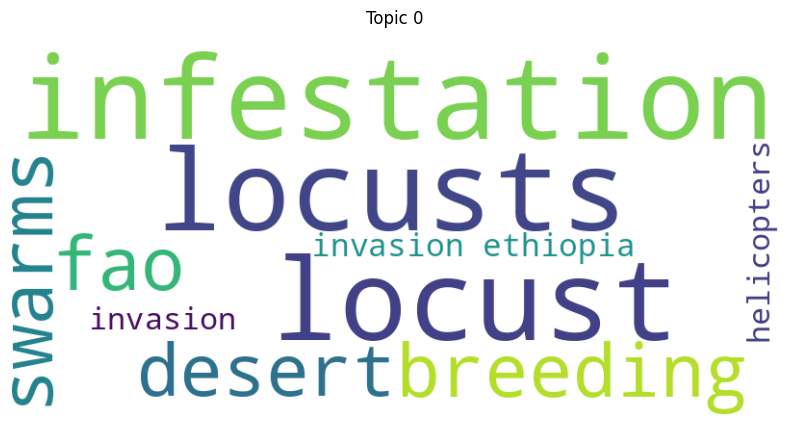

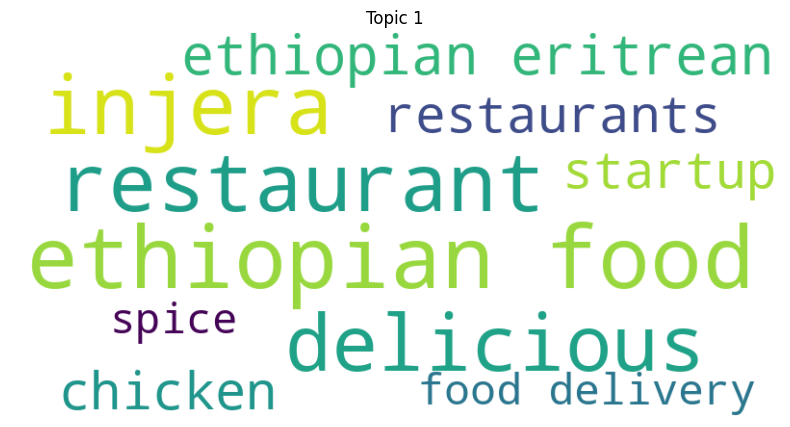

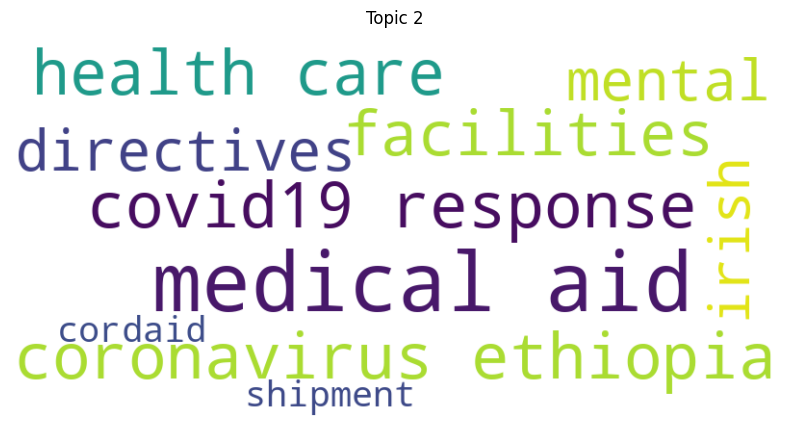

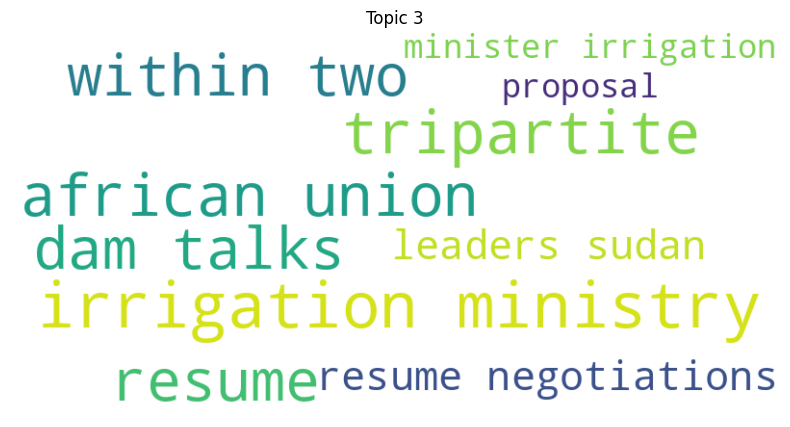

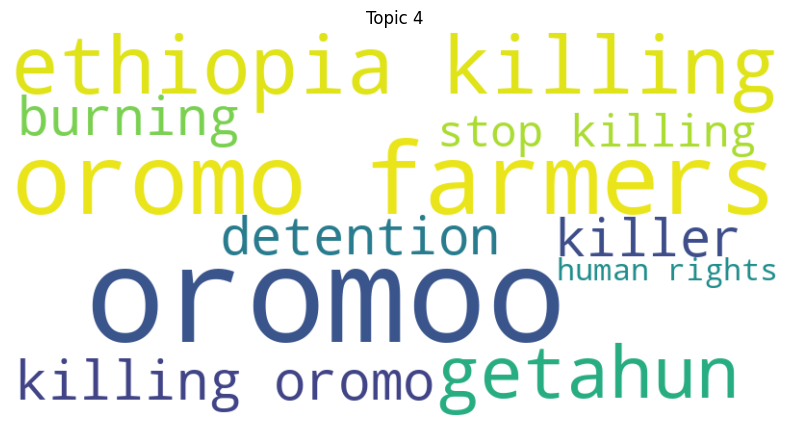

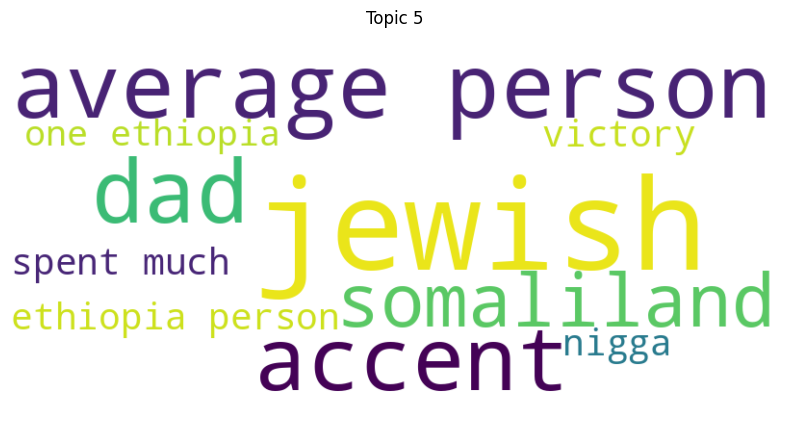

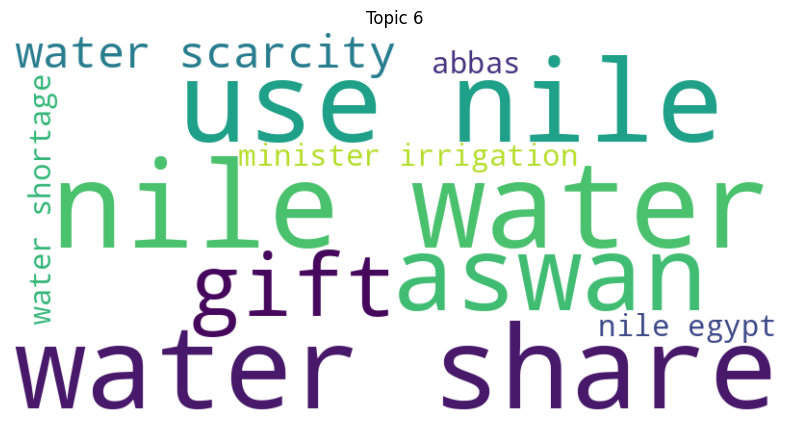

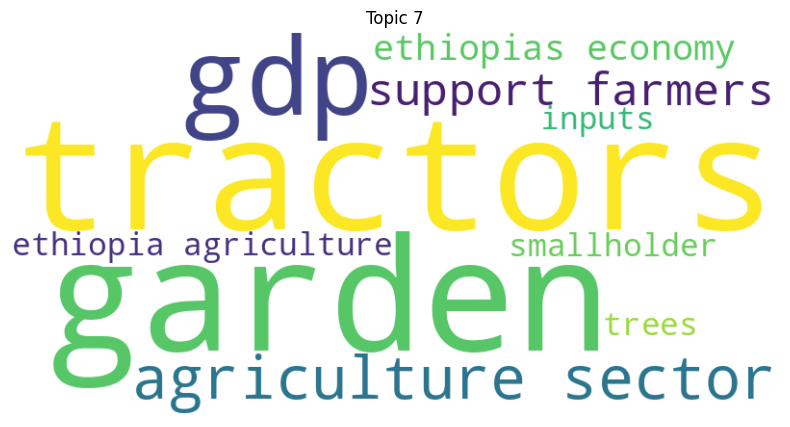

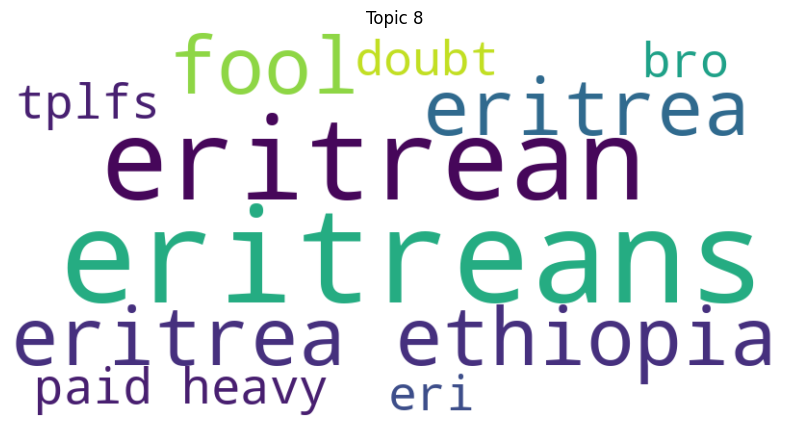

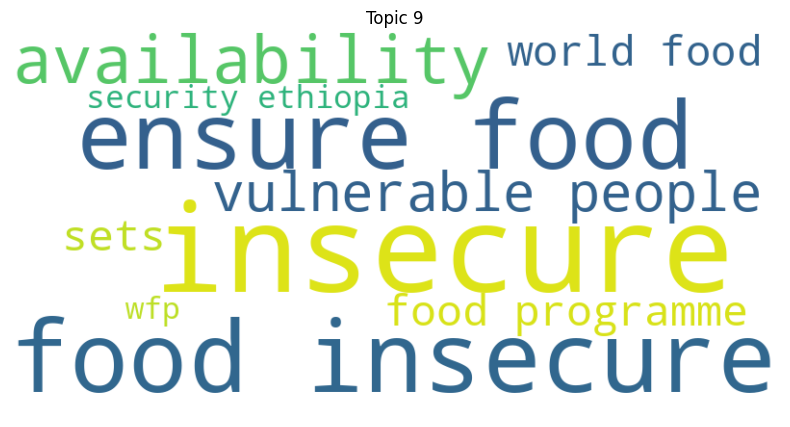

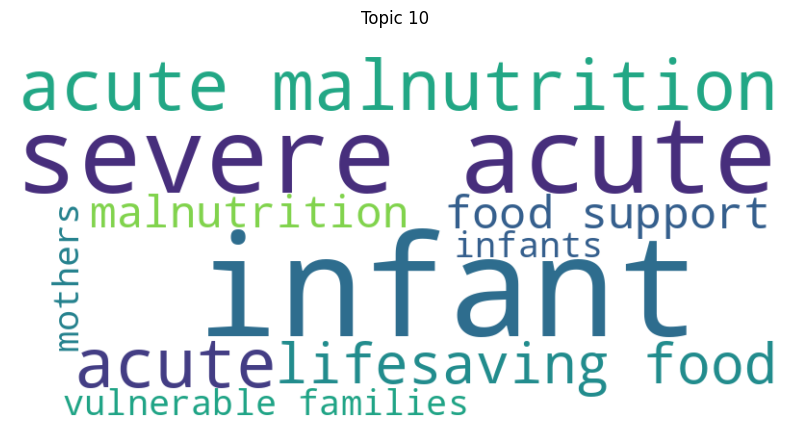

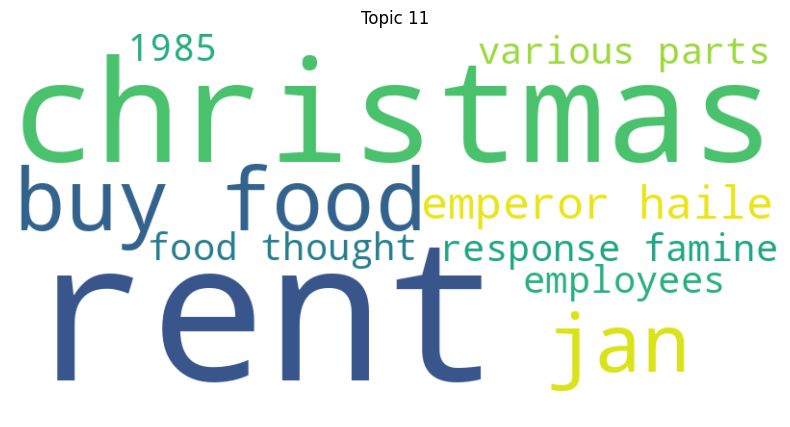

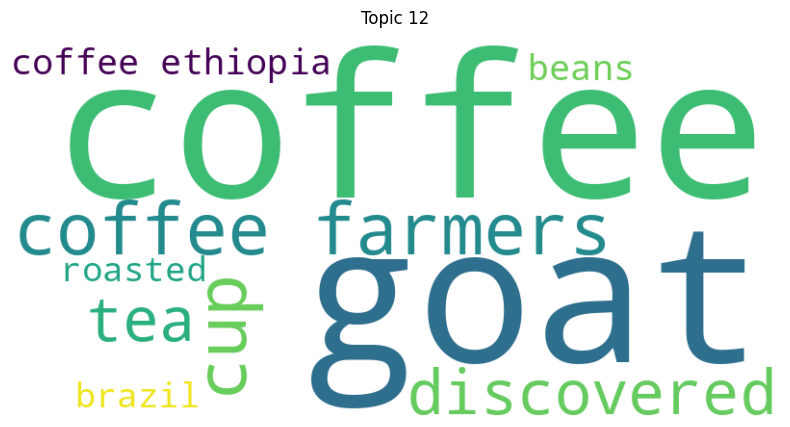

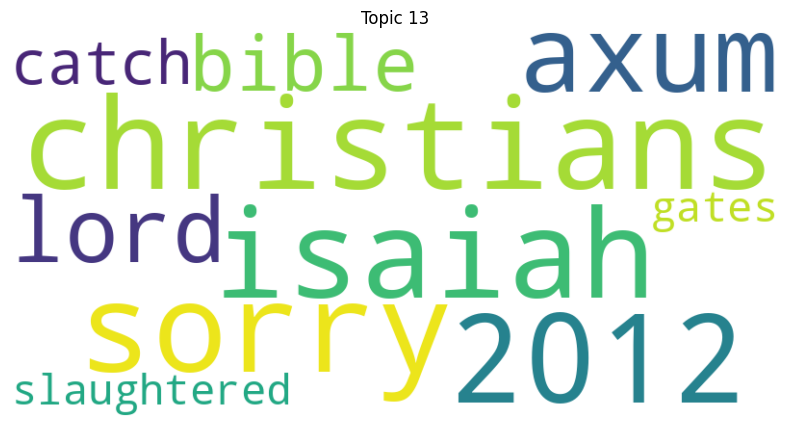

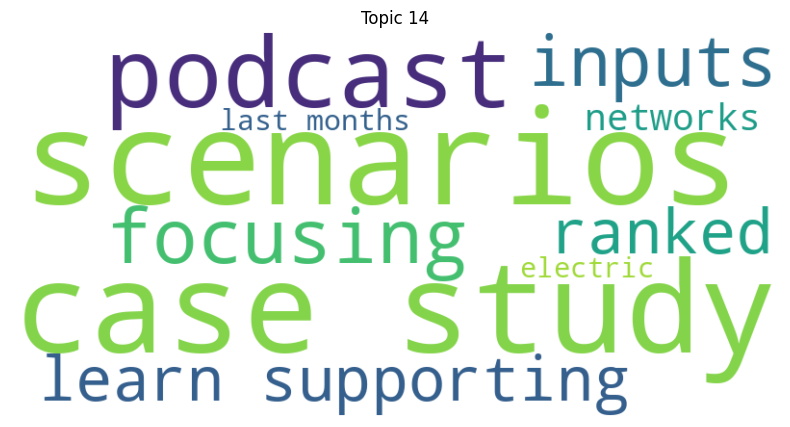

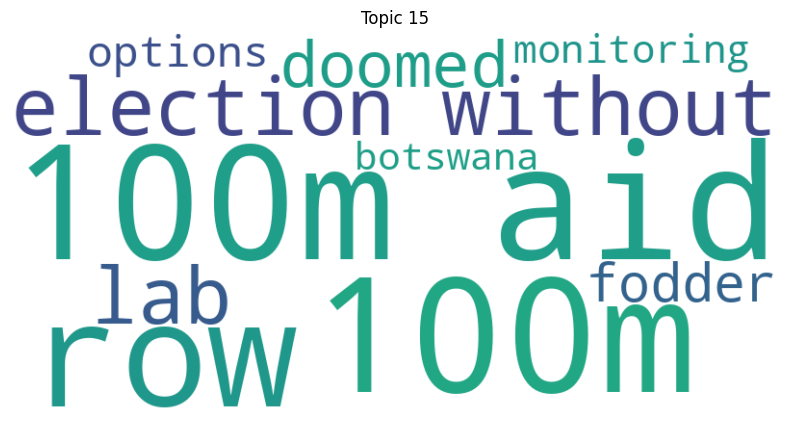

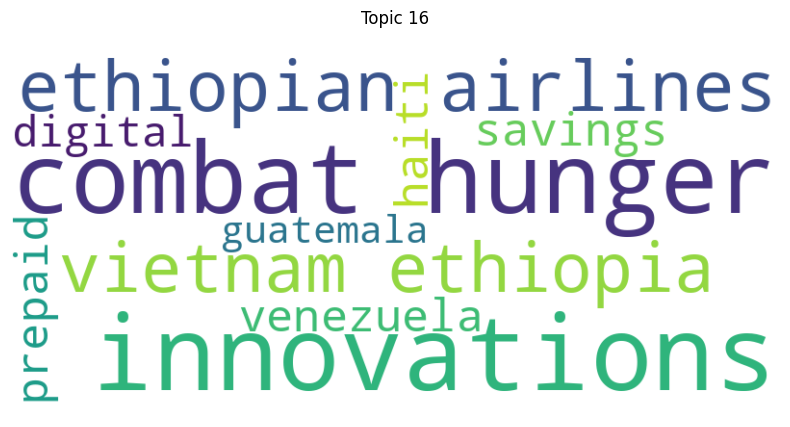

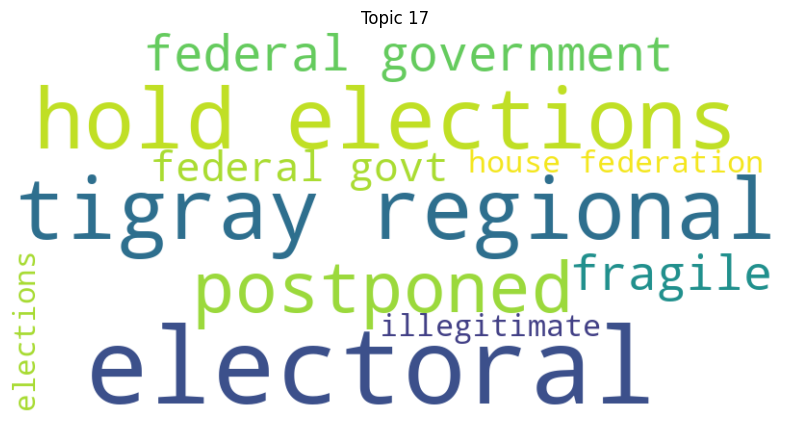

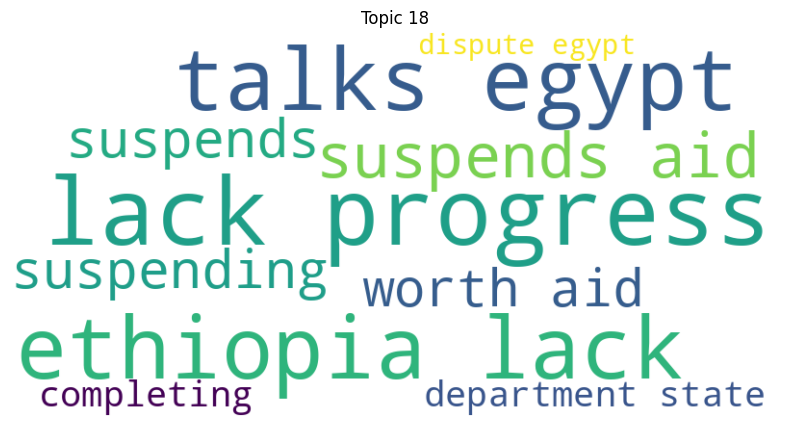

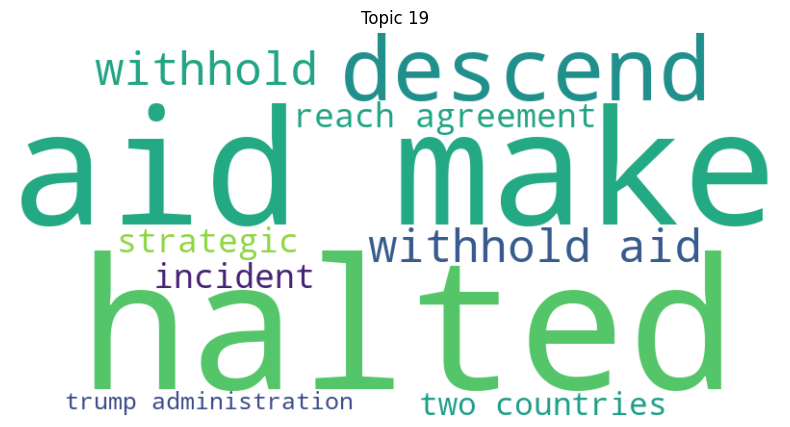

In [ ]:
# Step 1: Install wordcloud if not already installed
!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the new topic info and sort by topic size
new_topic_info = topic_model.get_topic_info()

# Filter out the outlier topic (-1) and get the top 20 topics
top_20_topics = new_topic_info[new_topic_info['Topic'] != -1].head(20)

# Step 2: Generate and display word clouds for the top 20 topics
for topic in top_20_topics['Topic']:
    # Extract the top words for the topic
    words = dict(topic_model.get_topic(topic))

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic}')
    plt.show()


## Reduce Topic Model (Optional)

In [ ]:
# Use only if need to reduce topics

# Step 5: Reduce the number of topics
topic_model = topic_model.reduce_topics(tweets_cleaned)

# Step 6: Get the reduced topic assignments for each tweet
reduced_topics = topic_model.transform(tweets_cleaned)[0]  # Topic assignments for each tweet

# Step 7: Add reduced topic assignments to the DataFrame
tweets_data['topic'] = reduced_topics  # Assign reduced topics to each tweet

# Step 8: Select the required columns for CSV
tweets_data_for_analysis = tweets_data[['created_at', 'cleaned_tweet', 'topic']]

# Step 9: Save the DataFrame to a CSV file for sentiment and volume analysis
tweets_data_for_analysis.to_csv('/content/Tweets_Topic_Assignment.csv', index=False)

# Optional: Display the first few rows to verify the data
print(tweets_data_for_analysis.head())

In [ ]:
# Optional: Save reduced topics information
reduced_topic_info_df = topic_model.get_topic_info()
reduced_topic_info_df.to_csv("/content/Reduced_BERTopic_Topic_Info.csv", index=False)

# Print the reduced topics and their top 10 keywords
for topic_num in reduced_topic_info_df['Topic']:
    if topic_num != -1:  # Exclude outliers
        keywords = topic_model.get_topic(topic_num)  # Get keywords for the topic
        print(f"Topic {topic_num}: {[word for word, _ in keywords[:10]]}")  # Print top 10 keywords

In [ ]:
# Visualize the topics in 2D space to observe their distances
topic_distance_fig_reduced = topic_model.visualize_topics()
topic_distance_fig_reduced.show()

In [ ]:
#Step 5: Post-processing: Balance classes by oversampling underrepresented topics
topic_counts = pd.Series(topics).value_counts()
dominant_topic = topic_counts.idxmax()  # Find the most frequent topic
minority_topics = topic_counts[topic_counts < 100].index  # Identify underrepresented topics

In [ ]:
# Initialize a dictionary to store representative tweets
topic_representatives = {}

# Step 3: Loop over unique topics and collect the tweets that belong to each topic
for topic in new_topic_info['Topic'].unique():
    if topic != -1:  # Exclude the "outliers" topic
        # Get the tweets corresponding to the current topic
        tweets_in_topic = [tweet for tweet, topic_num in zip(tweets_cleaned_unique, topics) if topic_num == topic]

        # Store only the first 5 representative tweets for each topic
        topic_representatives[topic] = tweets_in_topic[:5]

# Step 4: Convert the dictionary to a DataFrame for saving
representative_df = pd.DataFrame([(topic, tweet) for topic, tweets in topic_representatives.items() for tweet in tweets],
                                 columns=['Topic', 'Tweet'])

# Step 5: Save the representative tweets DataFrame to a CSV file
representative_df.to_csv("/content/Stage_1_BERTopic_Representative_Tweets", index=False)

In [ ]:
# Step 1: Install wordcloud if not already installed
!pip install wordcloud

# Step 2: Generate and display word clouds for each topic
for topic in new_topic_info['Topic']:
    if topic == -1:  # Skip the outlier topic (-1)
        continue

    # Extract the top words for the topic
    words = dict(topic_model.get_topic(topic))

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic}')
    plt.show()

In [ ]:
# Step 10: Get Dominant Topics
dominant_topics = topic_model.get_topic_info()
dominant_topics.head(10)

In [ ]:
# Apply the sentiment analysis to the 'cleaned_tweet' column
tweets_data['sentiment'] = tweets_data['cleaned_tweet'].apply(get_bert_sentiment)

# Step 6: Convert 'created_at' to datetime format
tweets_data['created_at'] = pd.to_datetime(tweets_data['created_at'])

# Step 7: Group by date and calculate the average sentiment score for each day
sentiment_per_day = tweets_data.groupby(tweets_data['created_at'].dt.date)['sentiment'].mean()

# Step 8: Reset index to prepare for calplot
sentiment_per_day = sentiment_per_day.reset_index()
sentiment_per_day.columns = ['Date', 'Sentiment']

# Ensure 'Date' is in datetime format
sentiment_per_day['Date'] = pd.to_datetime(sentiment_per_day['Date'])

# Set 'Date' as index for plotting
sentiment_per_day.set_index('Date', inplace=True)

<Figure size 1200x800 with 0 Axes>

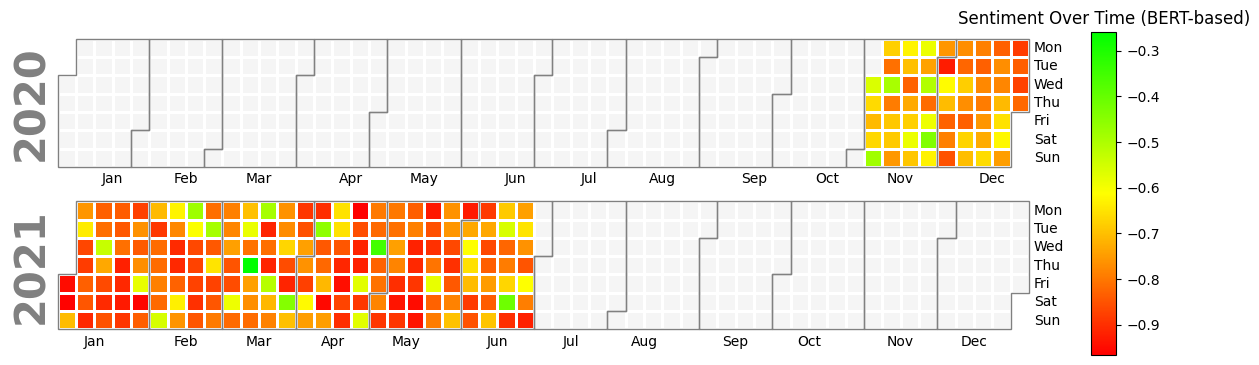

In [ ]:

from matplotlib.colors import LinearSegmentedColormap
# Step 1: Create a custom colormap from Red -> Yellow -> Green
colors = ["#FF0000", "#FFFF00", "#00FF00"]  # Red, Yellow, Green
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Step 2: Plot Sentiment Over Time Using Calplot
plt.figure(figsize=(12, 8))
calplot.calplot(sentiment_per_day['Sentiment'], cmap=cmap, colorbar=True)

# Step 3: Add title and show plot
plt.title("Sentiment Over Time (BERT-based)")
plt.show()

In [ ]:
# Display the first few rows of the sentiment_per_day dataframe
sentiment_per_day.head()

,Sentiment
Date,
2020-11-04,-0.563023
2020-11-05,-0.665144
2020-11-06,-0.708878
2020-11-07,-0.665529
2020-11-08,-0.481391


## Alterative Heatmap - assuming already ran BERTopic

Offline, I analyzed the ~65 original topics. I combined similar topics. I am uploading the file here "Stage 1 cut tweets..."

In [ ]:
#Make sure you have these
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the correct CSV file generated earlier
file_path = '/content/Stage 1 cut tweets_with_new_topic_numbers.csv'
df_new_tweets = pd.read_csv(file_path)

# Step 1: Ensure 'date' column is in datetime format
df_new_tweets['date'] = pd.to_datetime(df_new_tweets['date'])


In [ ]:
# Check the column names in the DataFrame
print(df_new_tweets.columns)


Index(['date', 'combined_topics'], dtype='object')


In [ ]:
# Step 2: Group by date and topic to get tweet volume per day per topic
# We will need to group by date and topic (which are now new topic numbers 0-12)
tweets_per_day = df_new_tweets.groupby([df_new_tweets['date'].dt.date, 'combined_topics']).size().unstack(fill_value=0)

# Step 5: Apply rolling average and normalize the data
rolling_window_length = 7  # Weekly rolling window

# Normalize each column and apply a rolling average
for col in tweets_per_day.columns:
    max_value = tweets_per_day[col].max()
    tweets_per_day[col] = (tweets_per_day[col] / max_value) * 100  # Normalize to percentage
    tweets_per_day[col] = tweets_per_day[col].rolling(window=rolling_window_length).mean()

In [ ]:
# Step 5: Map topic IDs to new custom topic names (ordered from highest to lowest volume)
custom_labels = {
    0: "Locust Plagues and Agriculture",           # 888 tweets
    1: "Nile Dam Dispute and Water Scarcity",       # 565 tweets
    2: "COVID-19 Aid, Health, and Case Response",   # 471 tweets
    3: "Food Security, Hunger Relief, and Innovations",  # 380 tweets
    4: "Aid Disruptions and Violence",              # 367 tweets
    5: "Ethnic Conflict and Agriculture",           # 345 tweets
    6: "Irrigation and Water Projects",             # 345 tweets
    7: "Agricultural Sector and Crop Production",   # 305 tweets
    8: "Political Tensions and Elections",          # 256 tweets
    9: "Famine, Crisis Recovery, and Food Aid",     # 243 tweets
    10: "Religious and Ethnic Conflicts",           # 213 tweets
    11: "Economic Impact and Pressures",            # 96 tweets
    12: "Food Supply Chains and Local Markets"      # 84 tweets
}


# Replace topic numbers with custom names in the DataFrame
tweets_per_day.columns = tweets_per_day.columns.map(custom_labels)

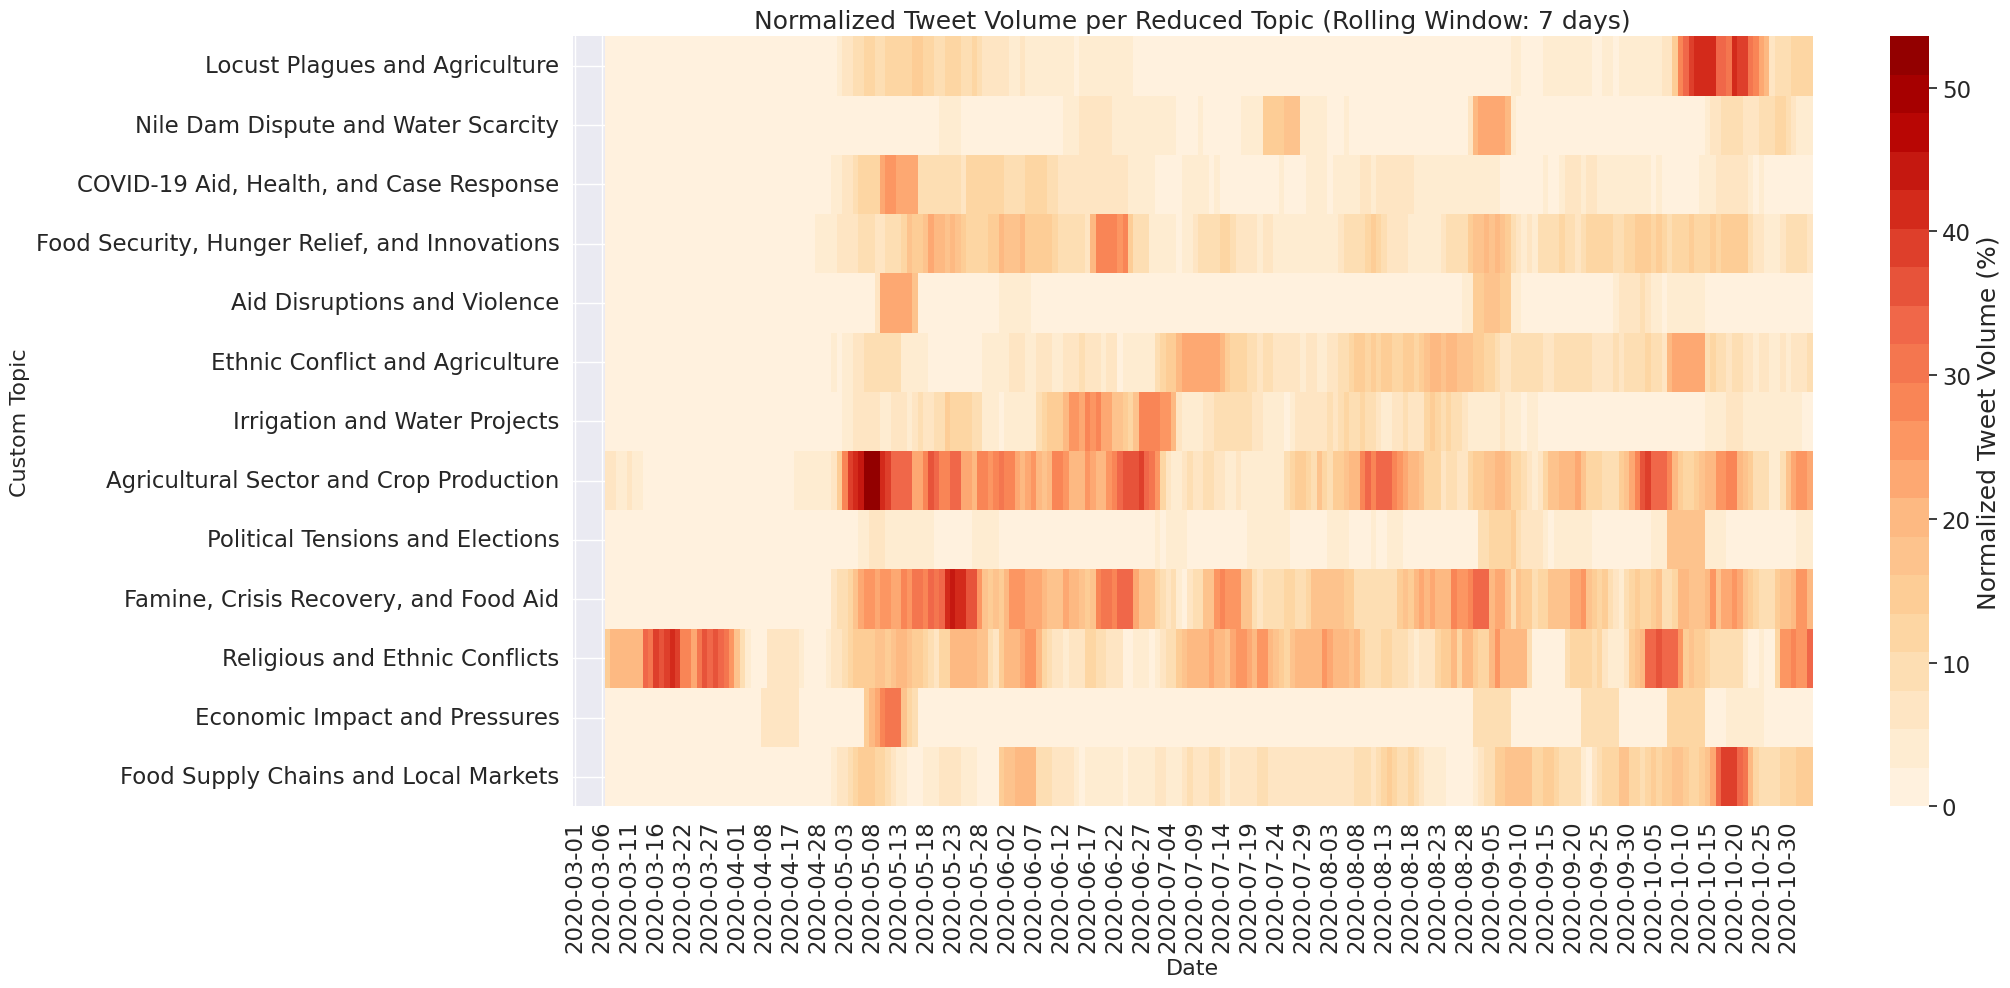

In [ ]:
# Step 7: Generate the heatmap
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(20, 10))

# Create the heatmap
sns.heatmap(tweets_per_day.T, cmap=sns.color_palette("OrRd", 20), cbar_kws={'label': 'Normalized Tweet Volume (%)'})

# Add title and labels
plt.title(f"Normalized Tweet Volume per Reduced Topic (Rolling Window: {rolling_window_length} days)", fontsize=18)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Custom Topic", fontsize=16)

# Show the heatmap
plt.show()

In [ ]:
# Save the heatmap as an image
plt.savefig('/content/Stage 1_Vol Per Topic Per Day_heatmap.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

## Alternative sentiment per topic per day

In [ ]:
!pip install transformers torch
from transformers import pipeline

In [ ]:
# Load the CSV file with tweets and topics
file_path = '/content/Stage 1 FULL tweets_with_new_topic_numbers.csv'
df_new_tweets = pd.read_csv(file_path)

# Ensure 'date' column is in datetime format
df_new_tweets['date'] = pd.to_datetime(df_new_tweets['date'])

In [ ]:
# Initialize the BERT sentiment analysis model
sentiment_analysis = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
# Apply sentiment analysis to each tweet and get a score
def get_sentiment_score(text):
    result = sentiment_analysis(text)[0]
    if result['label'] == 'POSITIVE':
        return result['score']  # Positive score from 0 to 1
    else:
        return -result['score']  # Negative score from 0 to -1

# Apply sentiment analysis to the 'tweet' column
df_new_tweets['sentiment'] = df_new_tweets['tweet'].apply(get_sentiment_score)

# Group by date and topic, and calculate the average sentiment per day per topic
sentiment_per_day = df_new_tweets.groupby([df_new_tweets['date'].dt.date, 'combined_topics'])['sentiment'].mean().unstack(fill_value=0)

KeyboardInterrupt: 

In [ ]:
# Optional - when Loading the CSV file into a DataFrame
file_path = '/content/Stage_1_tweets_with_sentiment_scores.csv'  # Path to the uploaded file
sentiment_data = pd.read_csv(file_path)

# Ensure 'date' column is in datetime format
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])

# Step 1: Group by date and topic, and calculate the average sentiment per day per topic
sentiment_per_day = sentiment_data.groupby([sentiment_data['date'].dt.date, 'combined_topics'])['sentiment'].mean().unstack(fill_value=0)


In [ ]:
# Print the column names to identify the correct sentiment column
print(sentiment_data.columns)

Index(['tweet', 'topic', 'date', 'combined_topics', 'sentiment'], dtype='object')


In [ ]:
 #Map topic numbers to custom labels (0-12) in the DataFrame
custom_labels = {
    0: "Locust Plagues and Agriculture",
    1: "Nile Dam Dispute and Water Scarcity",
    2: "COVID-19 Aid, Health, and Case Response",
    3: "Food Security, Hunger Relief, and Innovations",
    4: "Aid Disruptions and Violence",
    5: "Ethnic Conflict and Agriculture",
    6: "Irrigation and Water Projects",
    7: "Agricultural Sector and Crop Production",
    8: "Political Tensions and Elections",
    9: "Famine, Crisis Recovery, and Food Aid",
    10: "Religious and Ethnic Conflicts",
    11: "Economic Impact and Pressures",
    12: "Food Supply Chains and Local Markets"
}

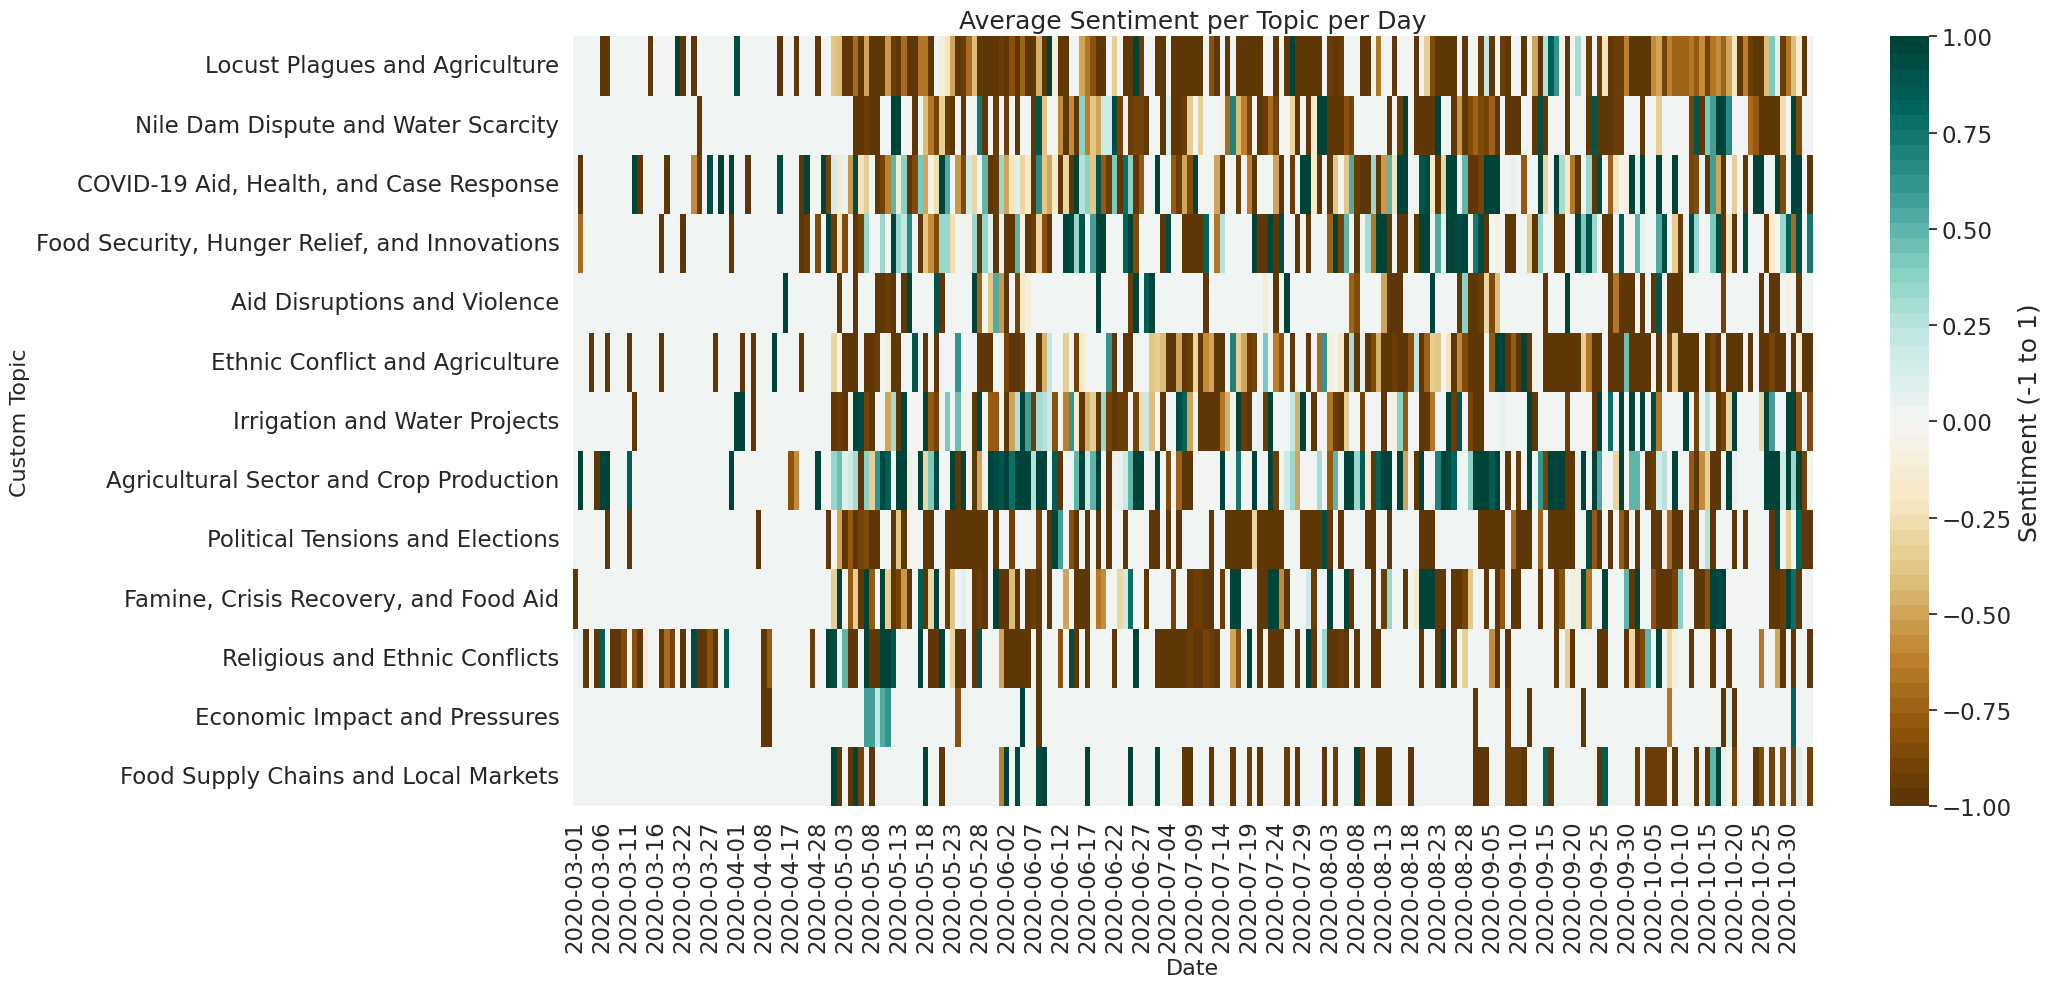

In [ ]:
# Step 3: Generate the heatmap with the corrected color scale and custom labels
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(20, 10))

# Ensure the custom labels have been mapped to the topic numbers
sentiment_per_day.columns = sentiment_per_day.columns.map(custom_labels)

# Create the heatmap with the correct sentiment scale (-1 to 1) and appropriate palette
sns.heatmap(sentiment_per_day.T, cmap=sns.color_palette("BrBG", 50), vmin=-1, vmax=1, cbar_kws={'label': 'Sentiment (-1 to 1)'}, center=0)

# Add title and labels
plt.title(f"Average Sentiment per Topic per Day", fontsize=18)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Custom Topic", fontsize=16)

# Show the heatmap
plt.show()

In [ ]:
# Save the heatmap as an image
plt.savefig('/content/Stage 1_Per_Topic_sentiment_heatmap.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

## Sentiment Score Per Day (All topics)

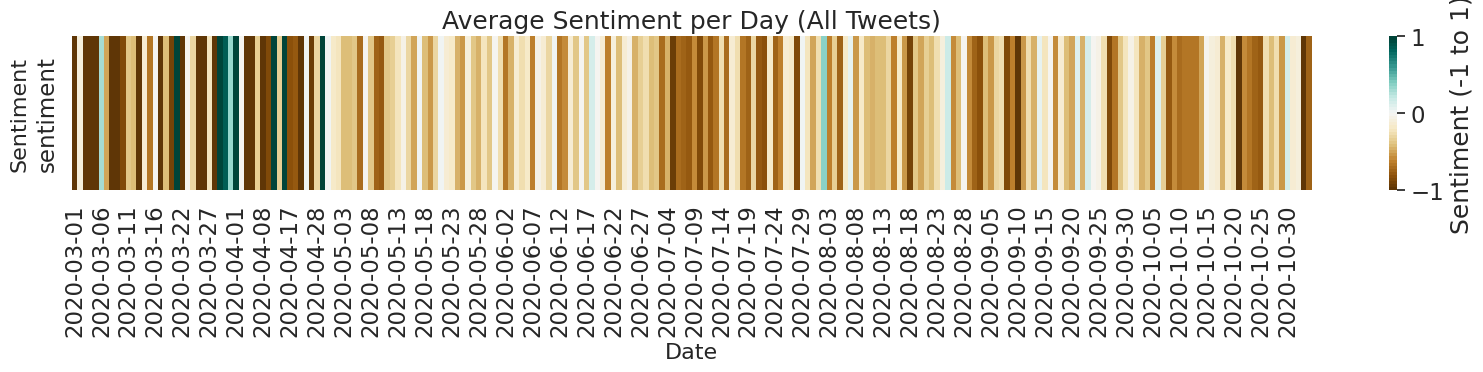

In [ ]:
# Load the CSV file with sentiment scores
file_path = '/content/Stage_1_tweets_with_sentiment_scores.csv'
df_new_tweets = pd.read_csv(file_path)

# Step 1: Ensure 'date' column is in datetime format
df_new_tweets['date'] = pd.to_datetime(df_new_tweets['date'])

# Step 2: Group by date and calculate the average sentiment per day (across all tweets)
sentiment_per_day = df_new_tweets.groupby(df_new_tweets['date'].dt.date)['sentiment'].mean()

# Step 3: Convert the sentiment per day into a DataFrame (for visualization)
sentiment_per_day_df = sentiment_per_day.to_frame().T  # Transpose to match heatmap structure

# Step 4: Generate the heatmap with the corrected color scale
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(20, 2))  # Adjusted height for a single-row heatmap

# Create the heatmap with the correct sentiment scale (-1 to 1) and appropriate palette
sns.heatmap(sentiment_per_day_df, cmap=sns.color_palette("BrBG", 50), vmin=-1, vmax=1, cbar_kws={'label': 'Sentiment (-1 to 1)'}, center=0)

# Add title and labels
plt.title(f"Average Sentiment per Day (All Tweets)", fontsize=18)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Sentiment", fontsize=16)

# Show the heatmap
plt.show()

In [ ]:
# Save the heatmap as an image
plt.savefig('/content/Stage 1_All_sentiment_heatmap.png', dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>